In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

In [7]:

# Anchored VWAP displays the volume-weighted average price for a specific time period, starting from a user-selected point. 
# Shows the price of an asset adjusted for its volume starting from any point chosen on the chart.
# This is a powerful tool because it takes into account the number of shares traded at each price level and presents it as a smooth line.
# https://school.stockcharts.com/doku.php?id=technical_indicators:anchored_vwap

def calc_vwap(df, anchor):
    if not anchor:
        temp_df = df.copy()
    elif anchor in df.index:
        temp_df = df.loc[anchor:].copy()
    else:
        raise ValueError('Anchor date not in index')

    temp_df['hlc'] = (temp_df['High'] + temp_df['Low'] + temp_df['Close']) / 3
    temp_df['vwap'] = (temp_df['hlc'] * temp_df['Volume']).cumsum() /temp_df['Volume'].cumsum()

    # find the 7 day MA
    temp_df['RSI'] = ta.rsi(temp_df['Close'], length=7)
    return temp_df








In [8]:
# Get daily_data from yahoo finance
daily_data = yf.download('SPY','2015-01-01','2023-01-24', interval='1D')
hourly_data = yf.download('SPY','2022-01-01','2023-01-24', interval='1h')
min_data = yf.download('SPY','2022-11-27','2023-01-24', interval='15m')

daily_data['hlc3'] = (daily_data['High'] + daily_data['Low'] + daily_data['Close']) / 3
hourly_data['hlc3'] = (hourly_data['High'] + hourly_data['Low'] + hourly_data['Close']) / 3
min_data['hlc3'] = (min_data['High'] + min_data['Low'] + min_data['Close']) / 3

#save the data to a csv file
daily_data.to_csv('datarepo/daily_data.csv')
hourly_data.to_csv('datarepo/hourly_data.csv')
min_data.to_csv('datarepo/min_data.csv')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


high price day: 2022-12-13 09:30:00-05:00
low price day: 2022-11-28 09:30:00-05:00
high volume day: 2022-11-30 09:30:00-05:00


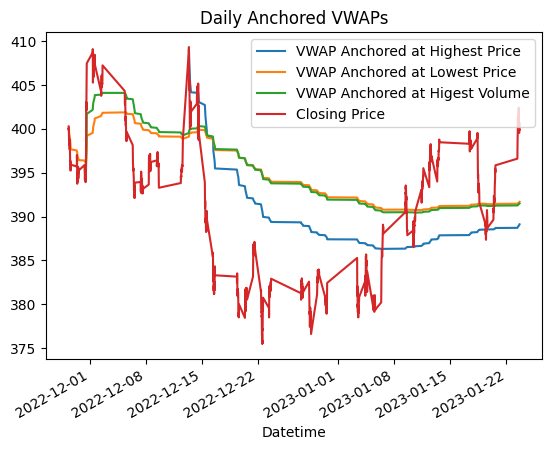

In [9]:
# Get daily_data from datarepo
daily_data = pd.read_csv('datarepo/daily_data.csv', index_col='Date', parse_dates=True)
hourly_data = pd.read_csv('datarepo/hourly_data.csv', index_col='Datetime', parse_dates=True)
min_data = pd.read_csv('datarepo/min_data.csv', index_col='Datetime', parse_dates=True)


def plotwaps(tf, lb_days):
    if tf == 'test_1D_vwap_and_candles':
        # find the date and time of the highest and lowest price and volume candles in the last lb periods (lookback)
        date_time_of_highest_price = daily_data['High'][len(daily_data)-lb_days:].idxmax()
        date_time_of_lowest_price = daily_data['Low'][len(daily_data)-lb_days:].idxmin()
        date_time_of_highest_volume = daily_data['Volume'][len(daily_data)-lb_days:].idxmax()

        # calculate the VWAP for the last lb periods (lookback) anchored at the date and time of the highest and lowest price and volume candles
        dthp_anchor = calc_vwap(daily_data, date_time_of_highest_price)['vwap']
        dtlp_anchor = calc_vwap(daily_data, date_time_of_lowest_price)['vwap']
        dthv_anchor = calc_vwap(daily_data, date_time_of_highest_volume)['vwap']

        #fill the first N rows with NaNs so that the length of the series is the same as the original daily_data
        print("high price day: " + str(date_time_of_highest_price))
        print("low price day: " + str(date_time_of_lowest_price))
        print("high volume day: " + str(date_time_of_highest_volume))

        dthp_anchor.plot()
        dtlp_anchor.plot()
        dthv_anchor.plot()
        daily_data['Close'].plot()

        plt.title('Daily Anchored VWAPs')
        plt.legend(['VWAP Anchored at Highest Price', 'VWAP Anchored at Lowest Price', 'VWAP Anchored at Higest Volume', 'Closing Price'])
        plt.show()

    if tf == 'test_1h_vwap_and_candles':

        date_time_of_highest_price = hourly_data['High'][len(hourly_data)- int(lb_days * 6.5):].idxmax()
        date_time_of_lowest_price = hourly_data['Low'][len(hourly_data)- int(lb_days * 6.5):].idxmin()
        date_time_of_highest_volume = hourly_data['Volume'][len(hourly_data)- int(lb_days * 6.5):].idxmax()
        

        dthp_anchor = calc_vwap(hourly_data, date_time_of_highest_price)['vwap']
        dtlp_anchor = calc_vwap(hourly_data, date_time_of_lowest_price)['vwap']
        dthv_anchor = calc_vwap(hourly_data, date_time_of_highest_volume)['vwap']

        print("high price day: " + str(date_time_of_highest_price))
        print("low price day: " + str(date_time_of_lowest_price))
        print("high volume day: " + str(date_time_of_highest_volume))

        dthp_anchor.plot()
        dtlp_anchor.plot()
        dthv_anchor.plot()
        hourly_data['Close'].plot()

        plt.title('Hourly Anchored VWAPs')
        plt.legend(['VWAP Anchored at Highest Price', 'VWAP Anchored at Lowest Price', 'VWAP Anchored at Higest Volume', 'Closing Price'])
        plt.show()

    if tf == 'vwap-on-custom-resolution-data':

        price_resolution = daily_data
        
        date_time_of_highest_price = daily_data['High'][len(daily_data)-lb_days:].idxmax()
        date_time_of_lowest_price = daily_data['Low'][len(daily_data)-lb_days:].idxmin()
        date_time_of_highest_volume = daily_data['Volume'][len(daily_data)-lb_days:].idxmax()

        #date_time_of_highest_price must be converted to the nearest valid index in the hourly_data dataframe
        #the nearest valid index is the index of the first row in hourly_data that has a date greater than or equal to date_time_of_highest_price
        date_time_of_highest_price = price_resolution.index[price_resolution.index >= date_time_of_highest_price][0]
        date_time_of_lowest_price = price_resolution.index[price_resolution.index >= date_time_of_lowest_price][0]
        date_time_of_highest_volume = price_resolution.index[price_resolution.index >= date_time_of_highest_volume][0]

        dthp_anchor = calc_vwap(price_resolution, date_time_of_highest_price)['vwap']
        dtlp_anchor = calc_vwap(price_resolution, date_time_of_lowest_price)['vwap']
        dthv_anchor = calc_vwap(price_resolution, date_time_of_highest_volume)['vwap']
        
        print("high price day: " + str(date_time_of_highest_price))
        print("low price day: " + str(date_time_of_lowest_price))
        print("high volume day: " + str(date_time_of_highest_volume))

        dthp_anchor.plot()
        dtlp_anchor.plot()
        dthv_anchor.plot()
        price_resolution['Close'].plot()

        plt.title('Mixed Anchored VWAPs')
        plt.legend(['VWAP Anchored at Highest Price', 'VWAP Anchored at Lowest Price', 'VWAP Anchored at Higest Volume', 'Closing Price'])
        plt.show()

    if tf == 'vwap-on-daily-data-charted-on-intraday-data':

        price_resolution = min_data

        date_time_of_highest_price = daily_data['High'][len(daily_data)-lb_days:].idxmax()
        date_time_of_lowest_price = daily_data['Low'][len(daily_data)-lb_days:].idxmin()
        date_time_of_highest_volume = daily_data['Volume'][len(daily_data)-lb_days:].idxmax()

        #date_time_of_highest_price must be converted to the nearest valid index in the hourly_data dataframe

        date_time_of_highest_price = price_resolution.index[price_resolution.index >= date_time_of_highest_price][0]
        date_time_of_lowest_price = price_resolution.index[price_resolution.index >= date_time_of_lowest_price][0]
        date_time_of_highest_volume = price_resolution.index[price_resolution.index >= date_time_of_highest_volume][0]

        dthp_anchor = calc_vwap(min_data, date_time_of_highest_price)['vwap']
        dtlp_anchor = calc_vwap(min_data, date_time_of_lowest_price)['vwap']
        dthv_anchor = calc_vwap(min_data, date_time_of_highest_volume)['vwap']
        
        print("high price day: " + str(date_time_of_highest_price))
        print("low price day: " + str(date_time_of_lowest_price))
        print("high volume day: " + str(date_time_of_highest_volume))

        dthp_anchor.plot()
        dtlp_anchor.plot()
        dthv_anchor.plot()
        min_data['Close'].plot()

        plt.title('Daily Anchored VWAPs')
        plt.legend(['VWAP Anchored at Highest Price', 'VWAP Anchored at Lowest Price', 'VWAP Anchored at Higest Volume', 'Closing Price'])
        plt.show()


# min_data['Close'].plot()
# plt.xlim('2022-12-01', '2023-01-04')

# plotwaps(tf='1D', lb_days=10)
# plotwaps(tf='1h', lb_days=15)
plotwaps(tf='test_1D_vwap_and_candles', lb_days=55)

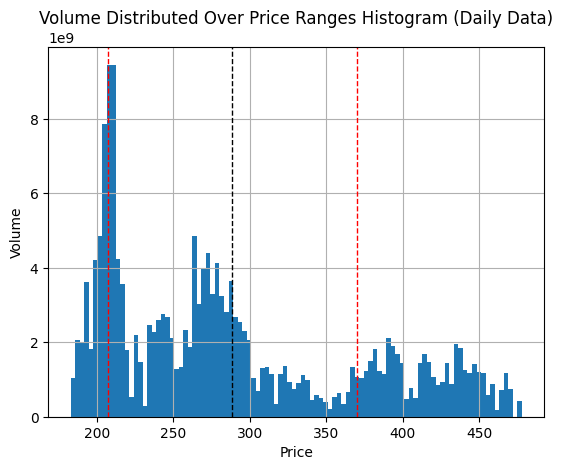

In [99]:

#now plot volume distributed over price ranges as bins in a histogram
plt.hist(daily_data['Close'], bins=100, weights=daily_data['Volume'])
#The mean of the daily_data is the average price weighted by volume

mean_of_vol_w_price = np.average(daily_data['Close'], weights=daily_data['Volume'])
#The standard deviation of the daily_data is the standard deviation of the price weighted by volume
std_price_w_vol = np.sqrt(np.average((daily_data['Close']-mean_of_vol_w_price)**2, weights=daily_data['Volume']))

sigma = std_price_w_vol

plt.axvline(mean_of_vol_w_price, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean_of_vol_w_price+float(sigma), color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean_of_vol_w_price-float(sigma), color='r', linestyle='dashed', linewidth=1)

plt.title('Volume Distributed Over Price Ranges Histogram (Daily Data)')
plt.xlabel('Price')
plt.ylabel('Volume')
#show grid
plt.grid(True)
#make the x axis bins more narrow

plt.show()
